# Amazon review classification with BERT

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!nvidia-smi

Sat Oct 10 23:36:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    29W /  70W |    227MiB / 15079MiB |      2%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<pre><font size=6> Preprocessing</font></pre>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
reviews = pd.read_csv(r"/Reviews.csv")
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
reviews.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [ ]:
reviews.drop(columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator','HelpfulnessDenominator', 'Time', 'Summary'],axis=1,inplace=True)

In [ ]:
reviews.columns

Index(['Score', 'Text'], dtype='object')

In [ ]:
np.unique(reviews.Score)

array([1, 2, 3, 4, 5])

In [ ]:
reviews.shape

(568454, 2)

In [ ]:
reviews.loc[reviews['Score'] <=2, 'Score'] = 0

In [ ]:
reviews.loc[reviews['Score'] > 3, 'Score'] = 1

In [ ]:
reviews.drop(reviews[reviews['Score']==3].index,inplace=True)

In [ ]:
reviews.shape

(525814, 2)

In [ ]:
reviews.head()

,Score,Text
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...


In [ ]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [ ]:
import re

Removing html tags from text

In [ ]:
reviews['Text']=reviews['Text'].apply(lambda row : re.sub('<.*?>','',row))

In [ ]:
reviews.head()

,Score,Text,len
64117,1,The tea was of great quality and it tasted lik...,30
418112,1,My cat loves this. The pellets are nice and s...,31
357829,1,Great product. Does not completely get rid of ...,41
175872,1,This gum is my favorite! I would advise every...,27
178716,1,I also found out about this product because of...,22


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews.drop(labels=['Score'],axis=1), reviews.Score, test_size=0.2, random_state=42, stratify=reviews.Score)

In [ ]:
X_train.shape,X_test.shape

((80000, 2), (20000, 2))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


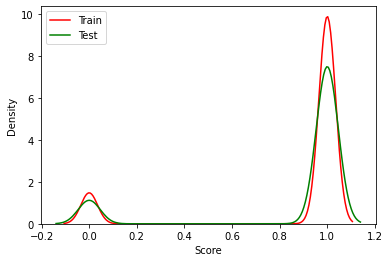

In [ ]:
 sns.distplot(y_train,hist=False,color='red',label='Train')
 sns.distplot(y_test,hist=False,color='green',label='Test')
 plt.legend()
 plt.show()

In [ ]:
reviews.to_csv('preprocessed.csv', index=False)

In [ ]:
tf.keras.backend.clear_session()

max_seq_length = 55

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector 
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [ ]:
bert_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 55)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
bert_model.output

<tf.Tensor 'keras_layer/StatefulPartitionedCall:0' shape=(None, 768) dtype=float32>

<pre><font size=6>Tokenization</font></pre>

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
pip install sentencepiece

     |████████████████████████████████| 1.1MB 8.5MB/s 


In [ ]:
!python3 tokenization.py

2020-10-10 23:37:21.762131: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
import tokenization

In [ ]:
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case)

Toeknizing each row

In [ ]:
def fun_tokenize(txt): #Tokenize each row
    list_token=[]
    for i in range(len(txt)):
        list_token.append(tokenizer.tokenize(txt.values[i]))
    return list_token

Considering first 53 words only for each row

In [ ]:
def trim_len(txt):
    list_token=[]
    for i in txt:
        list_token.append(i[0:(max_seq_length-2)])
    return list_token

Appending [CLS] at start and [SEP] at end for every row

In [ ]:
def fun_app(txt):
    list_app=[]
    for i in range(len(txt)):
        tt=[j for j in txt[i]]
        temp=['[CLS]']+tt+['[SEP]']
        list_app.append(temp)
    return list_app

COnverting tokens to ids

In [ ]:
def con_tok(lst):
    list_app=[]
    for i in lst:
        # print(i)
        list_app.append(np.array(tokenizer.convert_tokens_to_ids(i)))
    return list_app

Masking of every row to 0 and 1

In [ ]:
def mask_(lst):
    list_app=[]
    for i in range(len(lst)):
        list_app.append([1  if i>0 else 0 for i in lst[i]])
    return list_app

In [ ]:
len(X_train['Text'])

80000

In [ ]:
len(X_test['Text'])

20000

In [ ]:

X_train_tokens=fun_tokenize(X_train['Text'])
X_test_tokens=fun_tokenize(X_test['Text'])


X_train_tokens=trim_len(X_train_tokens)
X_test_tokens=trim_len(X_test_tokens)

X_train_tokens=fun_app(X_train_tokens)
X_test_tokens=fun_app(X_test_tokens)

X_train_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_train_tokens, padding="post",maxlen=55,dtype='<U25',value='[PAD]')
X_test_tokens = tf.keras.preprocessing.sequence.pad_sequences(X_test_tokens, padding="post",maxlen=55,dtype='<U25',value='[PAD]')

X_train_tokens=np.asarray(con_tok(X_train_tokens))
X_test_tokens=np.array(con_tok(X_test_tokens))

X_train_mask=np.array(mask_(X_train_tokens))
X_test_mask=np.array(mask_(X_test_tokens))

X_train_segment=np.zeros((len(X_train_tokens),max_seq_length))
X_test_segment=np.zeros((len(X_test_tokens),max_seq_length))

In [ ]:
import pickle

In [ ]:
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [ ]:
bert_model.input

[<tf.Tensor 'input_word_ids:0' shape=(None, 55) dtype=int32>,
 <tf.Tensor 'input_mask:0' shape=(None, 55) dtype=int32>,
 <tf.Tensor 'segment_ids:0' shape=(None, 55) dtype=int32>]

In [ ]:
bert_model.output

<tf.Tensor 'keras_layer/StatefulPartitionedCall:0' shape=(None, 768) dtype=float32>

In [ ]:
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [ ]:
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [ ]:
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [ ]:
X_test_pooled_output

array([[-0.6912516 , -0.47618595, -0.9702693 , ..., -0.9028027 ,
        -0.683657  ,  0.8173627 ],
       [-0.90906155, -0.47411022, -0.9511849 , ..., -0.88823247,
        -0.72597635,  0.93274844],
       [-0.87523824, -0.40808767, -0.8942015 , ..., -0.82421094,
        -0.63807225,  0.9167443 ],
       ...,
       [-0.87467194, -0.6071334 , -0.9854124 , ..., -0.9285754 ,
        -0.8442133 ,  0.8214854 ],
       [-0.932587  , -0.53329134, -0.9645862 , ..., -0.91946644,
        -0.78162783,  0.91889083],
       [-0.856434  , -0.2949976 , -0.9405685 , ..., -0.8936698 ,
        -0.6047819 ,  0.89804095]], dtype=float32)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

In [ ]:
import datetime
from sklearn.metrics import roc_auc_score
%load_ext tensorboard

In [ ]:
class LossHistory(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.history={'val_accuracy': []}


    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
        
        print('\n  train_auc : ',(roc_auc_score(y_train,(self.model.predict(X_train_pooled_output))) ))
        print('  val_auc : ',(roc_auc_score (y_test, (self.model.predict(X_test_pooled_output) ) ) ))
        loss=logs.get('loss')


In [ ]:
filepath="model1_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

history_own = LossHistory()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=2, verbose=1)

log_dir="logs_model1/fit/" + datetime.datetime.now().strftime("%H%M%S-%d%m%Y")   
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

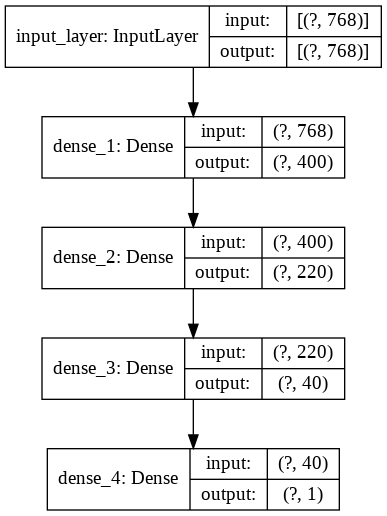

In [ ]:
input = Input(shape=[768,],name='input_layer')
dense1=Dense(400, activation='relu',name='dense_1')(input)
dense2=Dense(220, activation='relu',name='dense_2')(dense1)
dense3=Dense(40, activation='relu',name='dense_3')(dense2)
output=Dense(1, activation='sigmoid',name='dense_4')(dense3)
model1 = Model(inputs=input, outputs=output)
tf.keras.utils.plot_model(model1,"model_1.png",show_shapes=True)

In [ ]:
opt= tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics='accuracy')

In [ ]:
!rm -rf ./logs_model1/ 
tf.keras.backend.clear_session()
model1.fit(X_train_pooled_output,y_train,validation_data=[X_test_pooled_output,y_test],epochs=50,callbacks=[history_own,checkpoint,earlystop,tensorboard_callback] )

Epoch 1/50
   1/2500 [..............................] - ETA: 0s - loss: 1.0154 - accuracy: 0.1875WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


   2/2500 [..............................] - ETA: 5:21 - loss: 0.7756 - accuracy: 0.4844WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0072s vs `on_train_batch_end` time: 0.2500s). Check your callbacks.


2493/2500 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.9002
  train_auc :  0.9446367125081121
  val_auc :  0.9431181939077813

Epoch 00001: val_loss improved from inf to 0.00000, saving model to model1_save/weights-01-0.0000.hdf5
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2460 - accuracy: 0.9004 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
2485/2500 [============================>.] - ETA: 0s - loss: 0.2081 - accuracy: 0.9138
  train_auc :  0.9487478236242902
  val_auc :  0.9471178999123916

Epoch 00002: val_loss did not improve from 0.00000
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2081 - accuracy: 0.9138 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/50
2487/2500 [============================>.] - ETA: 0s - loss: 0.1953 - accuracy: 0.9203
  train_auc :  0.9521786589570054
  val_auc :  0.9510479434264071

Epoch 00003: val_loss did not improve from 0.00000
2500/2500 [==================

In [ ]:
%tensorboard --logdir logs_model1/fit